# Quick Regression

Let's see if we can predict something terribly!

In [100]:
# Bring in data
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Import LinearRegression
from sklearn.linear_model import LinearRegression
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
# Split the data
from sklearn.model_selection import train_test_split
# Optimize Parameters
from sklearn.model_selection import RandomizedSearchCV
# Import RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# Import GradientBoosted
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
# Import xgboost
import xgboost as xgb
# Import RSME
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
# Import Classification metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

with open('position_data.pickle', 'rb') as file:
    position_all = pickle.load(file)

In [101]:
pitcher_all.shape

(1033, 22)

In [102]:
position_all.shape

(1096, 21)

In [103]:
# Bring in models
lm = LinearRegression()
logr = LogisticRegression()
rf = RandomForestRegressor()
rfc = RandomForestClassifier()
gbr = GradientBoostingRegressor()
gbc = GradientBoostingClassifier()
xgr = xgb.XGBRegressor()
xgc = xgb.XGBClassifier()

In [104]:
# Create position one-hot configuration
position_all = pd.get_dummies(position_all, columns = ['Position'], prefix= ['Pos'])
pitcher_all = pd.get_dummies(pitcher_all, columns = ['Position'], prefix= ['Pos'])

# Create Contract logical variable
position_all['Contract'] = position_all.Dollars.notnull()
pitcher_all['Contract'] = pitcher_all.Dollars.notnull()

# Create AAV variable
position_all['AAV'] = position_all.Dollars_2006.divide(position_all.Length)
pitcher_all['AAV'] = pitcher_all.Dollars_2006.divide(pitcher_all.Length)
# Remove 2017 data
position_data = position_all[position_all.Year < 2017]
pitcher_data = pitcher_all[pitcher_all.Year < 2017]

# Designate interesting columns
features_pos = ['Age', 'WAR_3', 'G', 'OBP', 'SLG', 'HR', 'RBI', 'SB',
                'Med_WAR', 'Min_WAR', 'Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B',
                'Pos_SS', 'Pos_LF', 'Pos_CF', 'Pos_RF', 'Pos_DH']
features_pitch = ['Age', 'WAR_3', 'ERA', 'WHIP', 'K_9', 'HR_9', 'IPouts',
                  'W', 'SV', 'Med_WAR', 'Min_WAR', 'Pos_SP', 'Pos_RP']

position_all[['AAV', 'Dollars_2006', 'Length']].head(30)

,AAV,Dollars_2006,Length
0,NaN,NaN,0
1,NaN,NaN,0
2,7.500000e+05,750000.0,1
3,2.000000e+06,2000000.0,1
4,NaN,NaN,0
5,NaN,NaN,0
6,1.500000e+06,1500000.0,1
7,6.666667e+06,20000000.0,3
8,NaN,NaN,0
9,8.500000e+05,850000.0,1


## Predict yes/no on who will get a contract

In [82]:
# Position players first
# Grab just the features and the outcome
X_pos = position_data[features_pos].values
y_contract_pos = position_data['Contract'].values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_pos, y_contract_pos, random_state = 20, test_size = 0.1)

# Use the logr model
logr.fit(X_train, y_train)

print(logr.score(X_test, y_test))

y_pred = logr.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.722772277228
             precision    recall  f1-score   support

      False       0.71      0.71      0.71        48
       True       0.74      0.74      0.74        53

avg / total       0.72      0.72      0.72       101

[[34 14]
 [14 39]]


In [83]:
# Try random forest
rfc.fit(X_train, y_train)

print(rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.722772277228
             precision    recall  f1-score   support

      False       0.74      0.65      0.69        48
       True       0.71      0.79      0.75        53

avg / total       0.72      0.72      0.72       101

[[31 17]
 [11 42]]


In [84]:
# Try gradient boosting
gbc.fit(X_train, y_train)

print(gbc.score(X_test, y_test))

y_pred = gbc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.732673267327
             precision    recall  f1-score   support

      False       0.73      0.69      0.71        48
       True       0.73      0.77      0.75        53

avg / total       0.73      0.73      0.73       101

[[33 15]
 [12 41]]


In [85]:
# Now pitchers

# Grab just the features and the outcome
X_pitch = pitcher_data[features_pitch].values
y_contract_pitch = pitcher_data['Contract'].values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_pitch, y_contract_pitch, random_state = 20, test_size = 0.1)

# Use the logr model
logr.fit(X_train, y_train)

print(logr.score(X_test, y_test))

y_pred = logr.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.808510638298
             precision    recall  f1-score   support

      False       0.78      0.85      0.81        46
       True       0.84      0.77      0.80        48

avg / total       0.81      0.81      0.81        94

[[39  7]
 [11 37]]


In [86]:
# Try random forest
rfc.fit(X_train, y_train)

print(rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.755319148936
             precision    recall  f1-score   support

      False       0.72      0.83      0.77        46
       True       0.80      0.69      0.74        48

avg / total       0.76      0.76      0.75        94

[[38  8]
 [15 33]]


In [87]:
# Try gradient boosting
gbc.fit(X_train, y_train)

print(gbc.score(X_test, y_test))

y_pred = gbc.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.787234042553
             precision    recall  f1-score   support

      False       0.78      0.78      0.78        46
       True       0.79      0.79      0.79        48

avg / total       0.79      0.79      0.79        94

[[36 10]
 [10 38]]


## Functions for creating predictions for a year given that year

For now, these will use an OOTB gradient boosted model

In [88]:
# Define function for Dollars
def predictDollars(model, X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = 0.1)
    
    # Train the model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    plt.scatter(y_pred, y_test, color = 'blue')
    plt.xlabel('Predicted Dollars (millions)')
    plt.ylabel('Actual Dollars (millions)')
    plt.title('Prediction Contract Value')
    plt.yticks([0,4e7,8e7,1.2e8,1.6e8],['0','40','80','120','160'])
    plt.xticks([0,2e7,4e7,6e7,8e7,1e8],['0','20','40','60','80','100'])
    plt.text(x = 0, y = 1.5e8, s = "R^2 = {:0.3f}".format(model.score(X_test, y_test)))
    # plt.savefig('./contract_dollars_regression.png')
    plt.show()

    return model

In [89]:
# Definte function for contract length
def predictLength(model, X, y):
    
    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, test_size = 0.1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    plt.scatter(y_pred, y_test, color = 'red')

    plt.xlabel('Predicted Contract Length (years)')

    plt.ylabel('Actual Contract Length (years)')

    plt.title('Prediction Contract Length')
    plt.text(x = 1, y = 7, s = "R^2 = {:0.3f}".format(model.score(X_test, y_test)))
    #plt.savefig('./contract_length_regression.png')
    plt.show()

    return model

# First Task: Predict Yes/No on contract

We'll use a binary classifier (starting with Logistic Regression and moving on if needed) to:

1. Classify position players into "Yes/No" on contract
2. Classify pitchers into "Yes/No" on contract
3. Run RandomizedSearchCV to determine best parameters for each model


## Attempt 1: Batting Data w/ Team WAR

Woo!

### Step 1: Predict which players will get contracts

In [90]:


# For now, simulate dropping these
position_trimmed = position_data.dropna()

### Step 2: Predict how big the contracts will be

Make 2 models, and do it in 2006 dollars

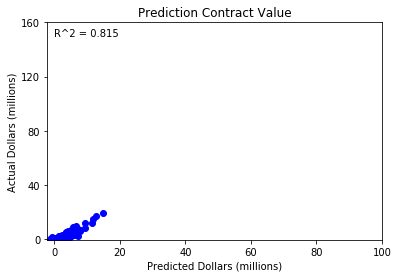

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [91]:
# Grab just the features and the outcome
X_pos = position_trimmed[features_pos].values
y_dollars_pos = position_trimmed['AAV'].values
y_length_pos = position_trimmed['Length'].values
predictDollars(lm, X_pos, y_dollars_pos)

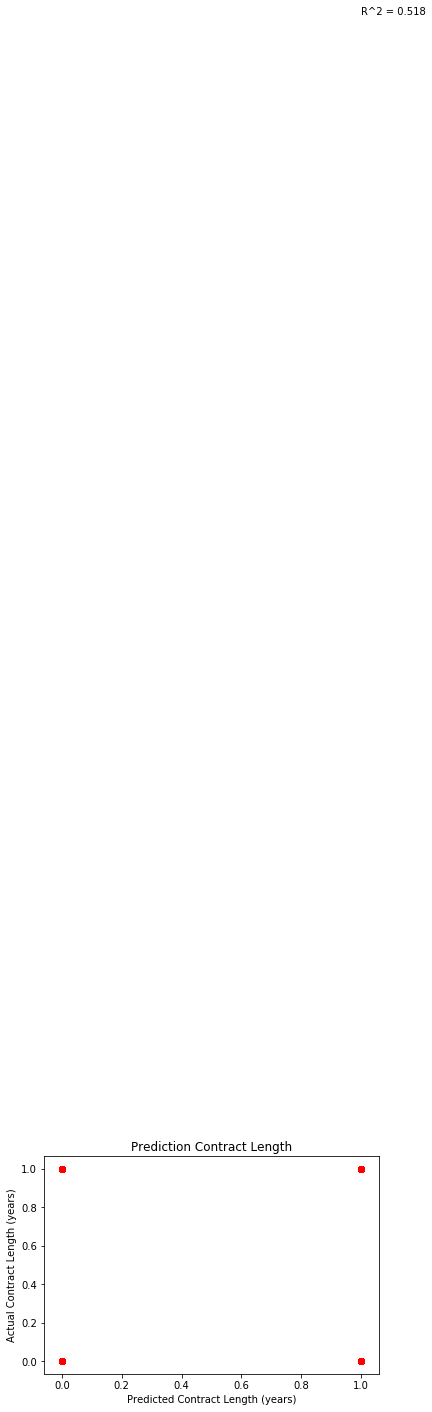

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [92]:
# Do length (This is wrong; need multi-class!)
logr = OneVsRestClassifier(LogisticRegression())

y_dummies  = pd.get_dummies(y_length_pos)

predictLength(logr, X_pos, y_dummies)

## Try Random Forest...now let's add Position to the matrix!

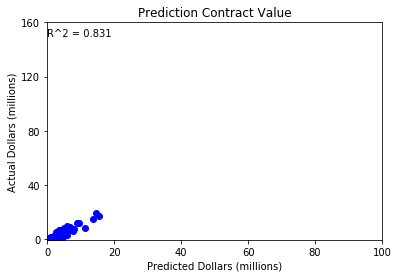

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [93]:
predictDollars(rf, X_pos, y_dollars_pos)

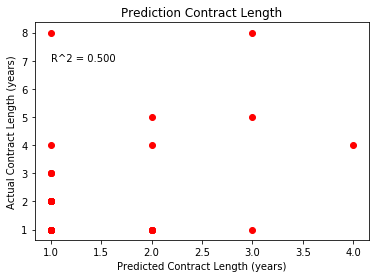

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
predictLength(rfc, X_pos, y_length_pos)

### Make quadratic terms

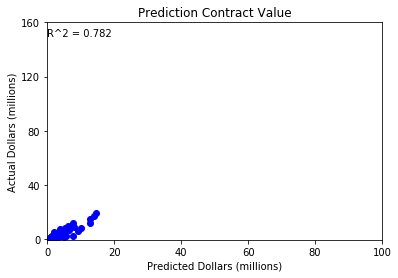

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [96]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
                   
poly = PolynomialFeatures()

something = poly.fit_transform(X_pos)

predictDollars(rf, something, y_dollars_pos)

## Try it for pitchers; straight to RF + LM!

In [105]:
# For now, simulate dropping these
pitcher_trimmed = pitcher_data.dropna()

X_pitch = pitcher_trimmed[features_pitch].values
y_dollars_pitch = pitcher_trimmed['AAV'].values
y_length_pitch = pitcher_trimmed['Length'].values

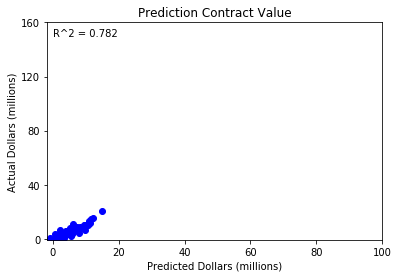

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [106]:
# Try the LM
predictDollars(lm, X_pitch, y_dollars_pitch)

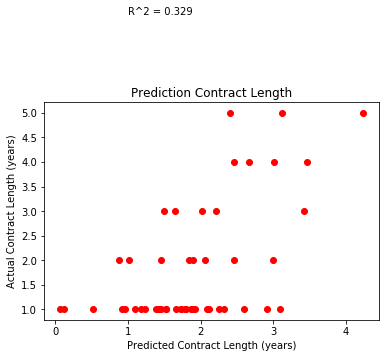

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [107]:
predictLength(lm, X_pitch, y_length_pitch)

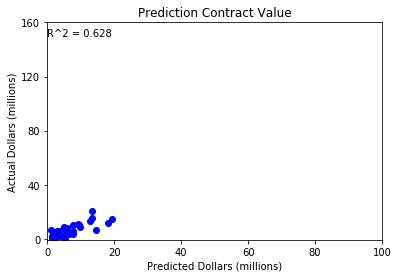

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [108]:
# Try RF
predictDollars(rf, X_pitch, y_dollars_pitch)

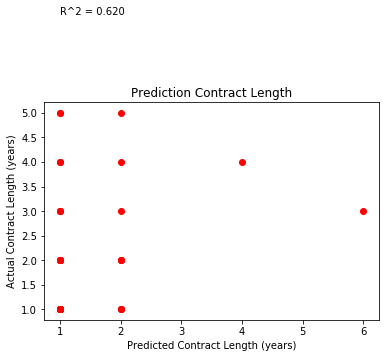

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [109]:
predictLength(rfc, X_pitch, y_length_pitch)

## Try Boosting (xgboost)

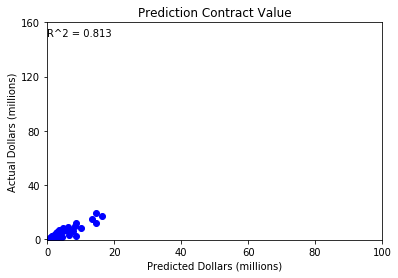

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [110]:
predictDollars(xgr, X_pos, y_dollars_pos)

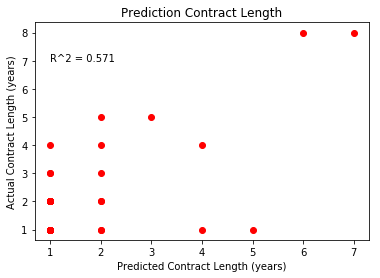

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [111]:
predictLength(xgc, X_pos, y_length_pos)

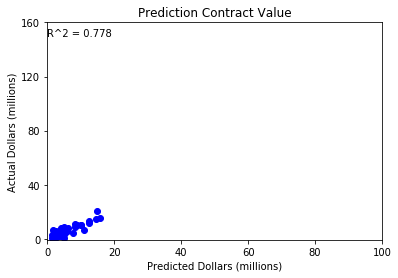

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [112]:
predictDollars(xgr, X_pitch, y_dollars_pitch)

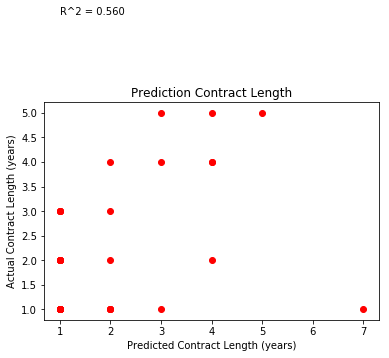

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [113]:
predictLength(xgc, X_pitch, y_length_pitch)

## Try boosting (sklearn)

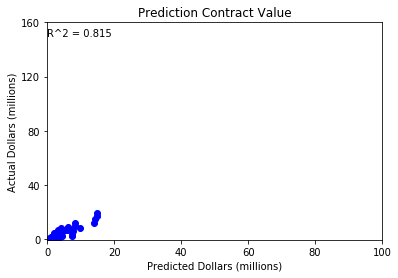

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [114]:
predictDollars(gbr, X_pos, y_dollars_pos)

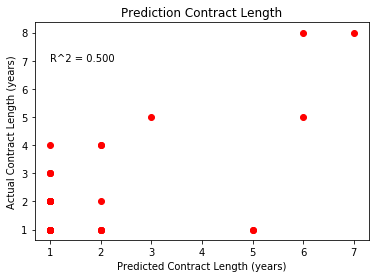

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [115]:
predictLength(gbc, X_pos, y_length_pos)

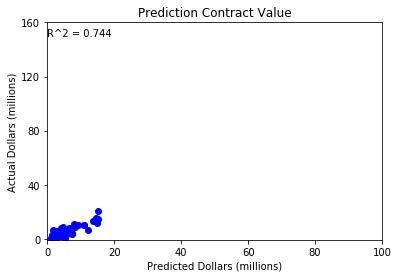

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [116]:
predictDollars(gbr, X_pitch, y_dollars_pitch)

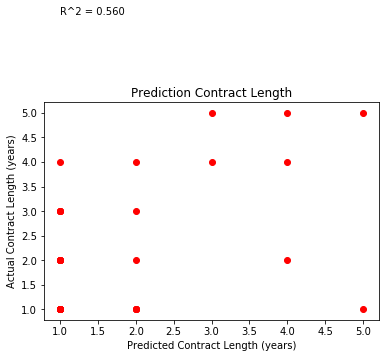

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [117]:
predictLength(gbc, X_pitch, y_length_pitch)

# I'm using GradientBoosted from sklearn....now I must:

1. Determine hyper-parameters using RandomizedSearchCV
2. Pull out feature importance

## 1. Hyper-parameters for position players

In [32]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000, 5000],
              "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbr_cv = RandomizedSearchCV(gbr, param_dist, cv=5)

# Fit it to the data
gbr_cv.fit(X_pos, y_dollars_pos)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbr_cv.best_params_))
print("Best score is {}".format(gbr_cv.best_score_))

Tuned Gradient Boosted Parameters: {'n_estimators': 5000, 'max_depth': 3, 'learning_rate': 0.05}
Best score is 0.6750448246033407


In [33]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000],
              "learning_rate": [0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbc_cv = RandomizedSearchCV(gbc, param_dist, cv=5)

# Fit it to the data
gbc_cv.fit(X_pos, y_length_pos)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbc_cv.best_params_))
print("Best score is {}".format(gbc_cv.best_score_))

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Tuned Gradient Boosted Parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1}
Best score is 0.592391304347826


# 2. Hyper-parameters for pitchers

In [34]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000, 5000],
              "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbr_cv = RandomizedSearchCV(gbr, param_dist, cv=5)

# Fit it to the data
gbr_cv.fit(X_pitch, y_dollars_pitch)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbr_cv.best_params_))
print("Best score is {}".format(gbr_cv.best_score_))

Tuned Gradient Boosted Parameters: {'n_estimators': 5000, 'max_depth': 3, 'learning_rate': 0.005}
Best score is 0.5652854073368493


In [35]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, 5, 7, 9],
              "n_estimators": [100, 500, 1000],
              "learning_rate": [0.01, 0.05, 0.1]}

# Instantiate the RandomizedSearchCV object: tree_cv
gbc_cv = RandomizedSearchCV(gbc, param_dist, cv=5)

# Fit it to the data
gbc_cv.fit(X_pitch, y_length_pitch)

# Print the tuned parameters and score
print("Tuned Gradient Boosted Parameters: {}".format(gbc_cv.best_params_))
print("Best score is {}".format(gbc_cv.best_score_))

/home/matt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Tuned Gradient Boosted Parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05}
Best score is 0.47265625


## 3. Use correct hyperparameters to train models and pull out feature importance

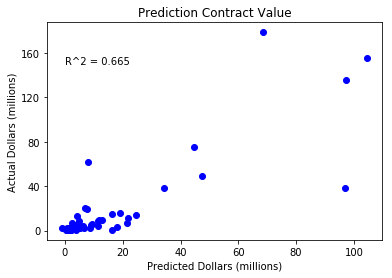

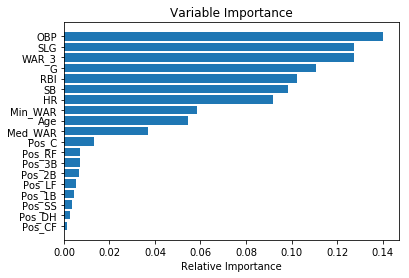

In [36]:
gbr_pos = GradientBoostingRegressor(max_depth = 3, n_estimators = 1000, learning_rate = 0.1)
gbr_pos_out = predictDollars(gbr_pos, X_pos, y_dollars_pos)

# Make a pretty plot
sorted_idx = np.argsort(gbr_pos_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbr_pos_out.feature_importances_[sorted_idx], align='center')
labels = [features_pos[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

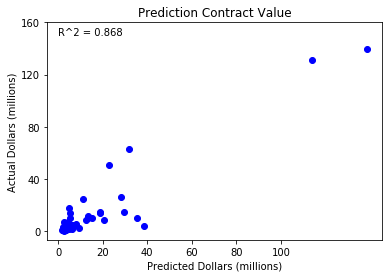

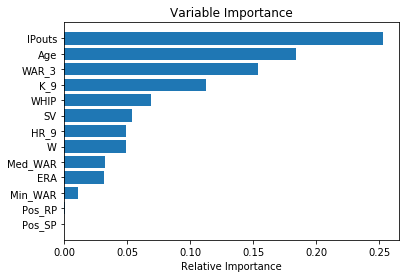

In [37]:
gbr_pitch = GradientBoostingRegressor(max_depth = 3, n_estimators = 5000, learning_rate = 0.001)
gbr_pitch_out = predictDollars(gbr_pitch, X_pitch, y_dollars_pitch)

# Make a pretty plot
sorted_idx = np.argsort(gbr_pitch_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbr_pitch_out.feature_importances_[sorted_idx], align='center')
labels = [features_pitch[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

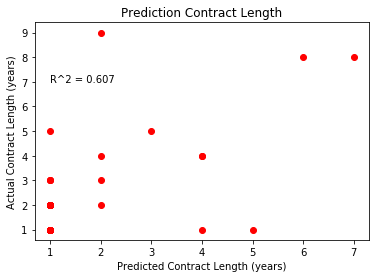

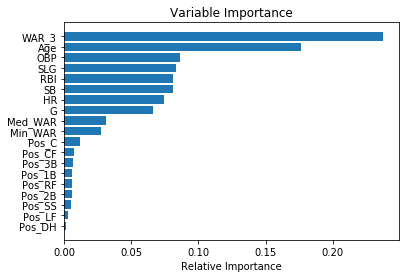

In [38]:
gbc_pos = GradientBoostingClassifier(max_depth = 3, n_estimators = 500, learning_rate = 0.01)
gbc_pos_out = predictLength(gbc_pos, X_pos, y_length_pos)

# Make a pretty plot
sorted_idx = np.argsort(gbc_pos_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbc_pos_out.feature_importances_[sorted_idx], align='center')
labels = [features_pos[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

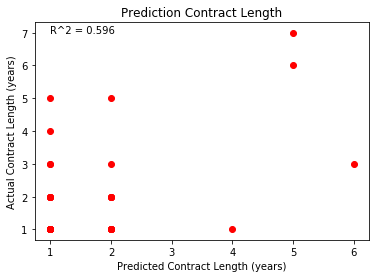

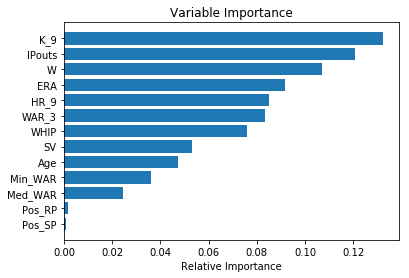

In [39]:
gbc_pitch = GradientBoostingClassifier(max_depth = 5, n_estimators = 1000, learning_rate = 0.01)
gbc_pitch_out = predictLength(gbc_pitch, X_pitch, y_length_pitch)

# Make a pretty plot
sorted_idx = np.argsort(gbc_pitch_out.feature_importances_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, gbc_pitch_out.feature_importances_[sorted_idx], align='center')
labels = [features_pitch[i] for i in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Things the final model should do:

1. Take in a given year
2. Remove that year AND 2017 from the training data
3. For each player in that year, predict:
   1. Whether they will get a major league contract
   2. If "yes", length and total dollars of contract
       1. First, predict in 2006 dollars
       2. Then, grab the inflation table and translate to appropriate year's dollars
   3. If "no", fill in with N/A and 0 (or no major league contract)

In [40]:
position_all.shape

(867, 31)

In [41]:
position_all[position_all.Year < 2017].shape

(851, 31)

In [42]:
pitcher_all[pitcher_all.Year < 2016].shape

(748, 33)

In [43]:
pitcher_all.shape

(865, 33)

In [236]:
pitcher_all[(pitcher_all.Year != 2016) & (pitcher_all.Year != 2017)].shape

(748, 23)

In [118]:
import importlib
import models
models = importlib.reload(models)

In [119]:
with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

pitcher_prepped = models.prepareFreeAgentData(pitcher_all)
X_train, y_train, X_test, y_test = models.splitDataByYear(pitcher_prepped, 2014, 'pitcher')

In [120]:
pitcher_prepped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033 entries, 0 to 1069
Data columns (total 25 columns):
Age                 1033 non-null int64
WAR_3               1033 non-null float64
nameFirst           1033 non-null object
nameLast            1033 non-null object
Year                1033 non-null int64
Dollars             529 non-null float64
Length              1033 non-null int64
playerID            1033 non-null object
yearID              1033 non-null int64
ERA                 1033 non-null float64
WHIP                1033 non-null float64
K_9                 1033 non-null float64
HR_9                1033 non-null float64
IPouts              1033 non-null float64
W                   1033 non-null float64
SV                  1033 non-null float64
Med_WAR             1033 non-null float64
Min_WAR             1033 non-null float64
Inflation_Factor    1033 non-null float64
Total               1033 non-null float64
Dollars_2006        529 non-null float64
Pos_RP              1033

In [41]:
contract_model, contract_preds = models.predictContract(X_train, y_train, X_test)

In [42]:
length_model, length_preds = models.predictLength(X_train, y_train, X_test)

In [43]:
dollars_model, dollars_preds = models.predictDollars(X_train, y_train, X_test) 

In [44]:
contract_model.score(X_test, y_test['Contract'])

0.83606557377049184

In [46]:
X_test_short = X_test[y_test.AAV_2006.notnull()]
y_test_short = y_test[y_test.AAV_2006.notnull()]
type(y_test_short)

pandas.core.frame.DataFrame

In [47]:
length_model.score(X_test_short, y_test_short['Length'])

0.6428571428571429

In [48]:
dollars_model.score(X_test_short, y_test_short['AAV_2006'])

0.76505278374475838

In [49]:
pitcher_prepped[pitcher_prepped.Year == 2016]['Inflation_Factor'].unique()[0]

1.6924528301886792

In [51]:
fa_year = 2006

# Load and prepare the datasets                                                                                                                                                             
#pitcher_all, position_all = models.loadAllData()
with open('pitching_data.pickle', 'rb') as file:
    pitcher_all = pickle.load(file)

with open('position_data.pickle', 'rb') as file:
    position_all = pickle.load(file)

pitcher_prepped = models.prepareFreeAgentData(pitcher_all)
position_prepped = models.prepareFreeAgentData(position_all)

# Use year to split dataset                                                                                                                                                                 
X_train_pitch, y_train_pitch, X_test_pitch, y_test_pitch = models.splitDataByYear(pitcher_prepped, fa_year, 'pitcher')
X_train_pos, y_train_pos, X_test_pos, y_test_pos = models.splitDataByYear(position_prepped, fa_year, 'position')

# Predict whether they'll get contracts                                                                                                                                                     
score_pitch, contract_pitch = models.predictContract(X_train_pitch, y_train_pitch, X_test_pitch)
_, contract_pos = models.predictContract(X_train_pos, y_train_pos, X_test_pos)

    # Predict contract length                                                                                                                                                                   
_, length_pitch = models.predictLength(X_train_pitch, y_train_pitch, X_test_pitch)
_, length_pos = models.predictLength(X_train_pos, y_train_pos, X_test_pos)

# Predict contract dollars                                                                                                                                                                  
_, dollars_pitch = models.predictDollars(X_train_pitch, y_train_pitch, X_test_pitch)
_, dollars_pos = models.predictDollars(X_train_pos, y_train_pos, X_test_pos) 

In [60]:
inflation_factor = pitcher_prepped[pitcher_prepped.Year == fa_year]['Inflation_Factor'].unique()[0]

test = pd.DataFrame({'nameFirst' : pitcher_prepped[pitcher_prepped.Year == fa_year]['nameFirst'].values,
              'nameLast' : pitcher_prepped[pitcher_prepped.Year == fa_year]['nameLast'].values,
              'position' : pitcher_all[pitcher_prepped.Year == fa_year]['Position'],
              'contract_pred' : contract_pitch,
              'contract_actual' : y_test_pitch['Contract'],
              'length_pred' : length_pitch,
              'length_actual': y_test_pitch['Length'],
              'dollars_pred' : np.round(dollars_pitch * length_pitch * inflation_factor, decimals = -5),
              'dollars_actual' : y_test_pitch['Dollars']})
test_small = test
test_small

,contract_actual,contract_pred,dollars_actual,dollars_pred,length_actual,length_pred,nameFirst,nameLast,position
0,False,False,NaN,2600000.0,0,1,Bruce,Chen,SP
1,True,True,3100000.0,3200000.0,1,1,Steve,Trachsel,SP
2,False,True,NaN,2600000.0,0,1,Mark,Redman,SP
3,True,True,3000000.0,4400000.0,1,1,David,Wells,SP
4,True,True,3500000.0,3000000.0,1,1,Tony,Armas,SP
5,False,False,NaN,1400000.0,0,1,Victor,Zambrano,SP
6,True,True,1500000.0,2100000.0,1,1,Tomo,Ohka,SP
7,True,True,3100000.0,3300000.0,1,1,Ramon,Ortiz,SP
8,True,False,500000.0,2100000.0,1,1,John,Thomson,SP
9,True,True,13000000.0,1900000.0,2,1,Mark,Mulder,SP


In [392]:
test_small['dollars_actual'] = test_small['dollars_actual'].apply(lambda x: '{:,.2f}'.format(x))
test_small['dollars_pred'] = test_small['dollars_pred'].apply(lambda x: '{:,.2f}'.format(x))
test_small['dollars_actual'].replace({'nan':'N/A'}, inplace = True)
test_small.loc[test_small.contract_pred == False,'dollars_pred'] = 'N/A'
test_small.loc[test_small.contract_pred == False,'length_pred'] = 0

In [393]:
test_small

,contract_actual,contract_pred,dollars_actual,dollars_pred,length_actual,length_pred,nameFirst,nameLast,position
0,False,False,N/A,N/A,0,0,Bruce,Chen,SP
1,True,True,"3,100,000.00","2,396,481.42",1,1,Steve,Trachsel,SP
2,False,True,N/A,"2,686,779.53",0,1,Mark,Redman,SP
3,True,True,"3,000,000.00","3,549,930.84",1,1,David,Wells,SP
4,True,True,"3,500,000.00","2,407,506.55",1,1,Tony,Armas,SP
5,False,False,N/A,N/A,0,0,Victor,Zambrano,SP
6,True,True,"1,500,000.00","4,270,287.32",1,1,Tomo,Ohka,SP
7,True,True,"3,100,000.00","6,259,598.73",1,1,Ramon,Ortiz,SP
8,True,False,"500,000.00",N/A,1,0,John,Thomson,SP
9,True,True,"13,000,000.00","2,076,433.20",2,1,Mark,Mulder,SP


In [351]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 748 to 822
Data columns (total 9 columns):
contract_actual    75 non-null bool
contract_pred      75 non-null bool
dollars_actual     46 non-null float64
dollars_pred       75 non-null float64
length_actual      75 non-null int64
length_pred        75 non-null int64
nameFirst          75 non-null object
nameLast           75 non-null object
position           75 non-null object
dtypes: bool(2), float64(2), int64(2), object(3)
memory usage: 7.3+ KB


In [353]:
test['dollars_actual'].apply(lambda x: '${:,.2f}'.format(x))

748              $nan
749              $nan
750              $nan
751              $nan
752     $4,000,000.00
753              $nan
754              $nan
755     $3,000,000.00
756     $3,000,000.00
757    $12,000,000.00
758              $nan
759              $nan
760              $nan
761     $6,500,000.00
762     $3,000,000.00
763              $nan
764     $5,500,000.00
765     $2,050,000.00
766              $nan
767              $nan
768              $nan
769     $1,150,000.00
770    $11,000,000.00
771     $5,350,000.00
772              $nan
773    $80,000,000.00
774              $nan
775              $nan
776     $3,000,000.00
777    $16,000,000.00
            ...      
793    $62,000,000.00
794     $1,100,000.00
795    $11,000,000.00
796     $2,000,000.00
797    $30,500,000.00
798     $1,000,000.00
799              $nan
800              $nan
801              $nan
802              $nan
803     $3,000,000.00
804              $nan
805    $16,000,000.00
806     $3,500,000.00
807     $2

In [56]:
round(1001.1)

1001

In [59]:
np.round(1101119.1, decimals= -5)

1100000.0

In [63]:
pitcher_all[pitcher_all.Year == 2017].shape

(37, 23)

In [65]:
import dataScraping as ds

In [73]:
blah = ds.assembleFAContractsForYear(2017)
blah.shape

(223, 7)

In [69]:
blah[blah.nameLast == 'Darvish']

,Dollars,Length,Name,Position,Year,nameFirst,nameLast
51,--,,Yu Darvish,SP,2017,Yu,Darvish


In [71]:
all_fa_data = getAllFAData([2017])
all_fa_data.shape

/home/matt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/matt/Github/MLB_FA_Predictor/dataScraping.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  all_fa_contracts_real['Length'] = pd.to_numeric(all_fa_contracts_real['Length'])
/home/matt/Github/MLB_FA_Predictor/dataScraping.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

(64, 12)

In [72]:
bbref_fa = ds.compileFAsForYear(2017)
bbref_fa.shape

(171, 8)

In [76]:
bbref_fa[bbref_fa.nameLast == 'Darvish']

,Age,Destination,Full_Name,Origin,WAR_3,nameFirst,nameLast,Year
